# AI-driven morphoclimatic regional frequency modelling of sub-daily rainfall-extremes
**Authors**: Chiara Angileri, Niccolò Marzi, Shola Oshodi

## 0. Importing libraries

In [297]:
colab = False

if colab:
    !pip install fitter
    !pip install pydot
    !pip install graphviz
    from pathlib import Path
    from google.colab import drive
    drive.mount('/content/drive')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp

from scipy import stats


In [298]:
from importlib import reload  
from utils import util
util = reload(util)

In [299]:
# Set random seed for reproducibility
def fix_random_seed(seed=24):
    np.random.seed(seed)
    tf.random.set_seed(seed)

fix_random_seed()

## 1. Load and inspect the dataset

### 1.1. Load data

In [300]:
df, df_indexes_test = util.load_data(colab)
print(df.columns)

Index(['ID', 'Nome', 'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y', 'duration[h]', 'AMS',
       'mean_IdD', 'loc', 'scale', '99perc', '95perc', '80perc'],
      dtype='object')


In [301]:
df

,ID,Nome,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),...,X,Y,duration[h],AMS,mean_IdD,loc,scale,99perc,95perc,80perc
0,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,1.221239,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
1,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,0.778761,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
2,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.219018,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
3,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,0.979995,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
4,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.153287,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274542,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,696822.00,5044294.00,24,0.918877,82.927273,0.903636,0.193259,1.792657,1.477653,1.193513
274543,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,696822.00,5044294.00,24,0.950230,82.927273,0.903636,0.193259,1.792657,1.477653,1.193513
274544,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,696822.00,5044294.00,24,0.602938,82.927273,0.903636,0.193259,1.792657,1.477653,1.193513
274545,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,696822.00,5044294.00,24,0.877878,82.927273,0.903636,0.193259,1.792657,1.477653,1.193513


### 1.2. Preprocess and split the dataset

In [302]:
# Clean the dataset from the columns that are not useful
to_remove = ['Nome', 'loc', 'scale', '99perc', '95perc', '80perc']
df = df.drop(to_remove, axis=1, inplace=False)

# Unique duration values
DURATION = df['duration[h]'].unique()
print('Durations: ', DURATION)

Durations:  [ 1  3  6 12 24]


In [303]:
#drop duplicate rows

#df = df.drop_duplicates()
#df = df.reset_index(drop=True)
#df

#### 1.2.1 Split the dataset into train, validation and test

In [304]:
# Take the first 100 ID and use them to create the test sets
test_ID = df_indexes_test['ID'].to_list()[:100]
test_df = df[df['ID'].isin(test_ID)]
test_df.reset_index(drop=True, inplace=True)

# Drop the test set from df and then create the train sets and validation sets
df = df.drop(df[df['ID'].isin(test_ID)].index)
df.reset_index(drop=True, inplace=True)

validation_split = 0.1
df = df.sort_values(by=['ID'])
    
train_df, val_df = train_test_split(df, test_size=validation_split, shuffle=False)
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [305]:
train_df.head()

,ID,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),OrogrAdri_stdev(m),...,OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,duration[h],AMS,mean_IdD
0,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,426.348085,...,1923.808472,1948.225952,577.581116,484.327515,281.33847,633069.81,4890553.68,1,1.221239,28.250
1,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,426.348085,...,1923.808472,1948.225952,577.581116,484.327515,281.33847,633069.81,4890553.68,24,0.680425,199.875
2,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,426.348085,...,1923.808472,1948.225952,577.581116,484.327515,281.33847,633069.81,4890553.68,24,0.855535,199.875
3,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,426.348085,...,1923.808472,1948.225952,577.581116,484.327515,281.33847,633069.81,4890553.68,24,0.945591,199.875
4,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,426.348085,...,1923.808472,1948.225952,577.581116,484.327515,281.33847,633069.81,4890553.68,24,1.518449,199.875


#### 1.2.2 Standardize datasets

All the data is standardized using StandardScaler, while the AMS is standardized using Min-Max scaling specifying a range from 0.001 to 0.99 to respect the distribution constraints.

In [306]:
train_df_std = util.standardize(train_df, 'beta')
val_df_std = util.standardize(val_df, 'beta')
test_df_std = util.standardize(test_df, 'beta')

In [307]:
# column id must be integer
train_df_std['ID'] = train_df_std['ID'].astype(int)
val_df_std['ID'] = val_df_std['ID'].astype(int)
test_df_std['ID'] = test_df_std['ID'].astype(int)

# column duration must be integer
train_df_std['duration[h]'] = train_df_std['duration[h]'].astype(int)
val_df_std['duration[h]'] = val_df_std['duration[h]'].astype(int)
test_df_std['duration[h]'] = test_df_std['duration[h]'].astype(int)

In [308]:
train_df_std.head()

,ID,AMS,mean_IdD,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),...,MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
0,5001,0.192017,28.250,1,1.491097,0.251105,0.104265,-0.433165,2.356325,0.207127,...,-0.79254,1.031064,1.012611,0.623256,2.169919,4.627821,1.780453,4.58539,0.512238,-0.713267
1,5001,0.106853,199.875,24,1.491097,0.251105,0.104265,-0.433165,2.356325,0.207127,...,-0.79254,1.031064,1.012611,0.623256,2.169919,4.627821,1.780453,4.58539,0.512238,-0.713267
2,5001,0.134428,199.875,24,1.491097,0.251105,0.104265,-0.433165,2.356325,0.207127,...,-0.79254,1.031064,1.012611,0.623256,2.169919,4.627821,1.780453,4.58539,0.512238,-0.713267
3,5001,0.148610,199.875,24,1.491097,0.251105,0.104265,-0.433165,2.356325,0.207127,...,-0.79254,1.031064,1.012611,0.623256,2.169919,4.627821,1.780453,4.58539,0.512238,-0.713267
4,5001,0.238819,199.875,24,1.491097,0.251105,0.104265,-0.433165,2.356325,0.207127,...,-0.79254,1.031064,1.012611,0.623256,2.169919,4.627821,1.780453,4.58539,0.512238,-0.713267


In [309]:
train_df_std.describe()

,ID,AMS,mean_IdD,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),...,MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
count,233218.000000,233218.000000,233218.000000,233218.000000,2.332180e+05,2.332180e+05,2.332180e+05,2.332180e+05,2.332180e+05,2.332180e+05,...,2.332180e+05,2.332180e+05,2.332180e+05,2.332180e+05,2.332180e+05,2.332180e+05,2.332180e+05,2.332180e+05,2.332180e+05,2.332180e+05
mean,11047.209328,0.157177,57.052651,9.199200,7.507042e-17,7.409548e-17,-3.314798e-17,3.197805e-16,-8.228498e-16,4.874703e-17,...,-4.523724e-16,-2.412978e-16,1.774392e-16,7.799524e-17,-7.019572e-17,1.413664e-17,-2.924822e-18,1.160179e-16,8.111505e-16,-5.490865e-15
std,4333.130131,0.059101,31.051531,8.280664,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,5001.000000,0.001000,5.200000,1.000000,-1.061720e+00,-1.230453e+00,-1.400119e+00,-1.588764e+00,-4.361573e+00,-3.505169e+00,...,-1.386613e+00,-1.471702e+00,-1.677331e+00,-1.834339e+00,-1.613136e+00,-4.798978e-01,-1.574433e+00,-6.312755e-01,-1.985384e+00,-1.780799e+00
25%,8094.000000,0.117288,34.984444,3.000000,-7.450225e-01,-8.616555e-01,-9.477065e-01,-7.307816e-01,-5.899795e-01,-6.288559e-01,...,-8.936858e-01,-5.806414e-01,-7.799818e-01,-7.189705e-01,-7.835092e-01,-4.531067e-01,-8.066373e-01,-5.114469e-01,-9.065087e-01,-7.796086e-01
50%,12005.000000,0.146356,49.674286,6.000000,-2.934347e-01,-1.262639e-01,3.152787e-02,7.104603e-02,2.245623e-03,5.232118e-02,...,-4.642899e-02,-1.402476e-01,-1.361465e-01,-1.810079e-01,-2.345443e-01,-4.210953e-01,-2.259545e-01,-4.328924e-01,1.538823e-01,-2.911280e-01
75%,16065.000000,0.184222,70.343750,12.000000,4.626625e-01,6.164214e-01,7.001068e-01,6.817685e-01,6.276712e-01,6.737728e-01,...,6.758903e-01,3.750492e-01,6.410975e-01,5.143236e-01,5.747680e-01,-2.262652e-01,6.329709e-01,-9.903266e-02,7.807107e-01,7.872395e-01
max,20034.000000,0.990000,318.742857,24.000000,5.303011e+00,3.753508e+00,2.939412e+00,3.556897e+00,3.616815e+00,2.897017e+00,...,2.546467e+00,5.233349e+00,3.650529e+00,3.278702e+00,4.315496e+00,7.291909e+00,3.516737e+00,6.103627e+00,2.150008e+00,2.505157e+00


### 1.3 Add the guesses to datasets

Addition of estimated values of alpha e beta to be used as ground truth.

In [310]:
def add_alpha_beta(df):
 
    # create two empy columns for alpha and beta
    df['alpha'] = np.nan
    df['beta'] = np.nan
 
    for id in df['ID'].unique():
       
        for duration in DURATION:
            condition = (df['ID'] == id) & (df['duration[h]'] == duration)
            ams = df[condition]['AMS']
           
            
            if len(ams) < 29:
                a, b = np.nan, np.nan
            else:
                a, b, _, _ = stats.beta.fit(ams, floc=0, fscale=1)
                
                        
            df.loc[condition, 'alpha'] = a
            df.loc[condition, 'beta'] = b
 
    # if there are nan values
    #if df.isnull().values.any():
        #raise Exception('There are nan values in the dataframe')
    df.dropna(inplace=True)
 
    return df

In [315]:
#train_df_std = add_alpha_beta(train_df_std)
#val_df_std = add_alpha_beta(val_df_std)
test_df_std = add_alpha_beta(test_df_std)

In [245]:
test_df_std

,ID,AMS,mean_IdD,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),...,OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,alpha,beta
0,5005,0.344115,24.120313,1,-0.992678,-1.301733,-1.439474,-1.719179,-1.068454,0.724267,...,1.094854,0.460323,-1.131891,-0.353866,-1.263384,-0.384176,0.736077,-0.048661,4.698220,17.654443
1,5005,0.465334,24.120313,1,-0.992678,-1.301733,-1.439474,-1.719179,-1.068454,0.724267,...,1.094854,0.460323,-1.131891,-0.353866,-1.263384,-0.384176,0.736077,-0.048661,4.698220,17.654443
2,5005,0.168813,24.120313,1,-0.992678,-1.301733,-1.439474,-1.719179,-1.068454,0.724267,...,1.094854,0.460323,-1.131891,-0.353866,-1.263384,-0.384176,0.736077,-0.048661,4.698220,17.654443
3,5005,0.234085,24.120313,1,-0.992678,-1.301733,-1.439474,-1.719179,-1.068454,0.724267,...,1.094854,0.460323,-1.131891,-0.353866,-1.263384,-0.384176,0.736077,-0.048661,4.698220,17.654443
4,5005,0.175341,24.120313,1,-0.992678,-1.301733,-1.439474,-1.719179,-1.068454,0.724267,...,1.094854,0.460323,-1.131891,-0.353866,-1.263384,-0.384176,0.736077,-0.048661,4.698220,17.654443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15396,17020,0.235988,94.501724,24,1.367716,0.864384,0.400722,0.340169,1.394191,-2.275033,...,1.233921,0.747859,0.386188,1.552234,0.273613,1.787313,0.691368,1.858279,4.400665,16.572441
15397,17020,0.455421,94.501724,24,1.367716,0.864384,0.400722,0.340169,1.394191,-2.275033,...,1.233921,0.747859,0.386188,1.552234,0.273613,1.787313,0.691368,1.858279,4.400665,16.572441
15398,17020,0.123177,94.501724,24,1.367716,0.864384,0.400722,0.340169,1.394191,-2.275033,...,1.233921,0.747859,0.386188,1.552234,0.273613,1.787313,0.691368,1.858279,4.400665,16.572441
15399,17020,0.191720,94.501724,24,1.367716,0.864384,0.400722,0.340169,1.394191,-2.275033,...,1.233921,0.747859,0.386188,1.552234,0.273613,1.787313,0.691368,1.858279,4.400665,16.572441


In [246]:
test_df_std.describe()

,ID,AMS,mean_IdD,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),...,OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,alpha,beta
count,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,...,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000
mean,9388.486309,0.209098,53.389238,9.193265,-0.054454,-0.057300,-0.043374,-0.000175,0.003947,0.055561,...,-0.005121,-0.025633,-0.111956,-0.052278,-0.111327,-0.044623,0.048460,-0.051024,5.926968,22.312520
std,4006.986916,0.085906,25.339568,8.276588,0.965252,0.903036,0.955898,1.001340,1.023209,0.993475,...,0.989319,0.948977,0.840657,0.890517,0.876791,0.848388,1.002140,0.952704,2.413917,9.175408
min,5005.000000,0.001000,14.084211,1.000000,-1.057576,-1.318189,-1.445570,-1.726708,-2.142658,-2.275033,...,-1.991559,-2.092011,-1.357714,-0.423020,-1.486411,-0.636266,-1.972522,-1.379113,1.900445,7.076243
25%,5271.000000,0.150829,35.077632,3.000000,-0.691088,-0.669717,-0.759450,-0.611630,-0.696476,-0.825581,...,-0.815241,-0.788306,-0.831723,-0.382378,-0.826454,-0.479705,-0.648753,-0.701679,4.385808,16.527895
50%,8264.000000,0.192573,46.877778,6.000000,-0.332965,-0.175267,-0.226438,0.130077,-0.033415,0.258376,...,-0.002061,0.152431,-0.223946,-0.352460,-0.263285,-0.384176,0.071168,-0.285131,5.494201,20.694632
75%,12126.000000,0.246772,66.046429,12.000000,0.324500,0.505363,0.668262,0.604645,0.509563,0.775107,...,0.960440,0.665067,0.386188,-0.181619,0.556542,-0.016292,0.708506,0.391367,7.112111,26.856611
max,17020.000000,0.820991,159.706452,24.000000,4.545468,2.342999,1.938167,2.235533,2.405262,1.641952,...,1.515624,2.552776,1.806962,5.914061,2.184762,4.108021,1.923074,2.337351,18.230781,68.917125


In [247]:
#util.geographic_plot(train_df_std, 'alpha', 'beta')

In [248]:
#histogram of AMS when alpha > 90 and beta > 500

'''
condition = (train_df_std['alpha'] > 90) & (train_df_std['beta'] > 500)
ams = train_df_std[condition]['AMS']
print(len(ams))
print(ams.values)
a, b, _, _ = stats.beta.fit(ams, floc=0, fscale=1)
print(a, b)
m, d = stats.norm.fit(ams)
print(m, d)

x = np.linspace(0, 1, 100)
dist_norm = stats.norm.pdf(x, m, d)
dist_beta = stats.beta.pdf(x, a, b)

plt.plot(x, dist_norm, 'r-', lw=1, alpha=0.6, label='norm pdf')
plt.plot(x, dist_beta, 'b-', lw=1, alpha=0.6, label='beta pdf')
plt.legend()
plt.show()
'''

"\ncondition = (train_df_std['alpha'] > 90) & (train_df_std['beta'] > 500)\nams = train_df_std[condition]['AMS']\nprint(len(ams))\nprint(ams.values)\na, b, _, _ = stats.beta.fit(ams, floc=0, fscale=1)\nprint(a, b)\nm, d = stats.norm.fit(ams)\nprint(m, d)\n\nx = np.linspace(0, 1, 100)\ndist_norm = stats.norm.pdf(x, m, d)\ndist_beta = stats.beta.pdf(x, a, b)\n\nplt.plot(x, dist_norm, 'r-', lw=1, alpha=0.6, label='norm pdf')\nplt.plot(x, dist_beta, 'b-', lw=1, alpha=0.6, label='beta pdf')\nplt.legend()\nplt.show()\n"

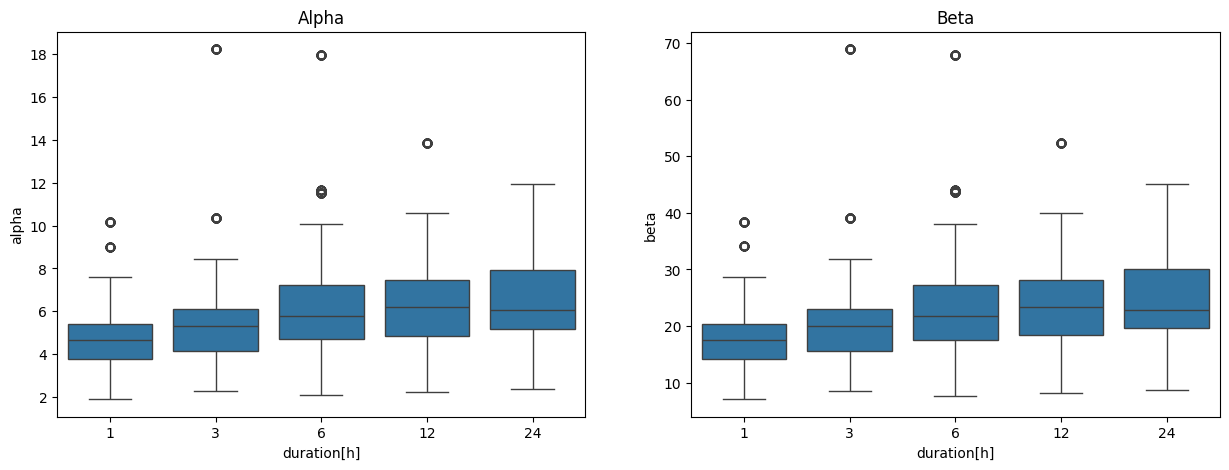

In [249]:
#boxplot of alpha and beta
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(x='duration[h]', y='alpha', data=test_df_std, ax=ax[0])
ax[0].set_title('Alpha')

sns.boxplot(x='duration[h]', y='beta', data=test_df_std, ax=ax[1])
ax[1].set_title('Beta')

plt.show()

In [250]:
#take the ID with the highest alpha and beta for each duration
'''
def get_highest_alpha_beta(df, duration):
    highest_alpha = df[df['duration[h]']==duration]['alpha'].max()
    highest_beta = df[df['duration[h]']==duration]['beta'].max()
    return highest_alpha, highest_beta

for duration in DURATION:
    highest_alpha, highest_beta = get_highest_alpha_beta(train_df_std, duration)
    highest_alpha_ID = train_df_std.loc[train_df_std['alpha'] == highest_alpha, 'ID'].values[0] # [0] because the array contains the same value repeated
    highest_beta_ID = train_df_std.loc[train_df_std['beta'] == highest_beta, 'ID'].values[0]
    
    print('Duration: ', duration)
    print('Highest alpha: ', highest_alpha)
    print('Highest alpha ID: ', highest_alpha_ID)
    print('Highest beta: ', highest_beta)
    print('Highest beta ID: ', highest_beta_ID)
    ams = train_df_std[(train_df_std['ID']==highest_beta_ID)&(train_df_std['duration[h]']==duration)]['AMS']
    print('\t AMS:', ams.values)
    print('\n')
    
'''

"\ndef get_highest_alpha_beta(df, duration):\n    highest_alpha = df[df['duration[h]']==duration]['alpha'].max()\n    highest_beta = df[df['duration[h]']==duration]['beta'].max()\n    return highest_alpha, highest_beta\n\nfor duration in DURATION:\n    highest_alpha, highest_beta = get_highest_alpha_beta(train_df_std, duration)\n    highest_alpha_ID = train_df_std.loc[train_df_std['alpha'] == highest_alpha, 'ID'].values[0] # [0] because the array contains the same value repeated\n    highest_beta_ID = train_df_std.loc[train_df_std['beta'] == highest_beta, 'ID'].values[0]\n    \n    print('Duration: ', duration)\n    print('Highest alpha: ', highest_alpha)\n    print('Highest alpha ID: ', highest_alpha_ID)\n    print('Highest beta: ', highest_beta)\n    print('Highest beta ID: ', highest_beta_ID)\n    ams = train_df_std[(train_df_std['ID']==highest_beta_ID)&(train_df_std['duration[h]']==duration)]['AMS']\n    print('\t AMS:', ams.values)\n    print('\n')\n    \n"

In [251]:
AMS_count = test_df_std.groupby(['ID','duration[h]'])['AMS'].count()
AMS_count = pd.DataFrame(AMS_count)
AMS_count.columns = ['count']
AMS_count['alpha'] = test_df_std.groupby(['ID','duration[h]'])['alpha'].mean() #prendo la media tanto lo stesso valore è ripetuto
AMS_count['beta'] = test_df_std.groupby(['ID','duration[h]'])['beta'].mean()

AMS_count.head(15)

count      alpha       beta
ID   duration[h]                             
5005 1               64   4.698220  17.654443
     3               64   4.985388  18.769508
     6               64   5.177795  19.481123
     12              64   5.422040  20.404289
     24              64   6.082947  22.912190
5015 1               76   7.601292  28.732540
     3               76  10.346514  39.078609
     6               77  10.068231  37.995353
     12              78   9.880190  37.303354
     24              77   8.419653  31.769764
5143 1               69   5.392633  20.326705
     3               70   6.141717  23.192353
     6               70   7.026472  26.596657
     12              70   4.710854  17.756734
     24              70   6.579026  24.854327

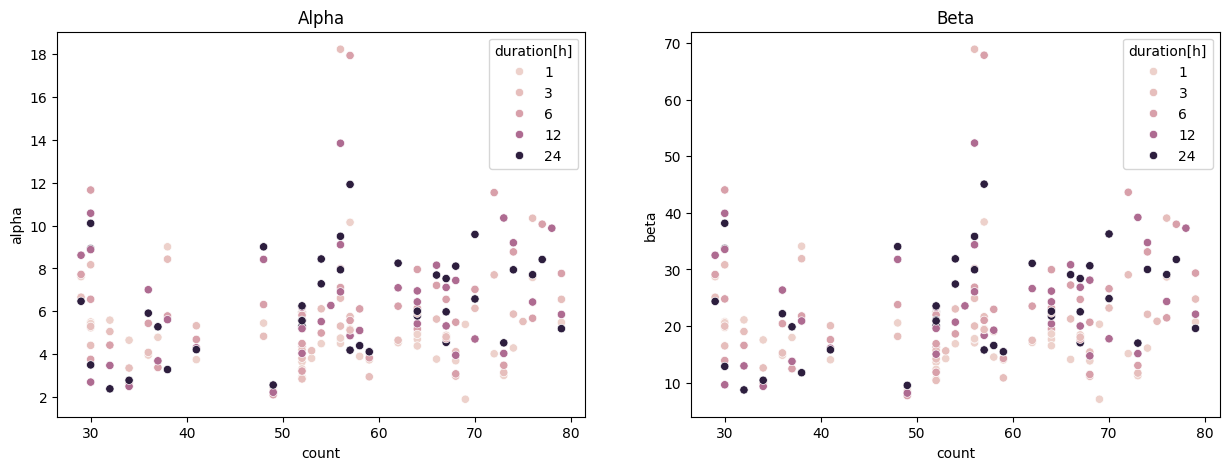

In [252]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.scatterplot(x='count', y='alpha', data=AMS_count, ax=ax[0], hue='duration[h]')
ax[0].set_title('Alpha')

sns.scatterplot(x='count', y='beta', data=AMS_count, ax=ax[1], hue='duration[h]')
ax[1].set_title('Beta')

plt.show()

### 1.4. Prepare data for training

In [253]:
# sort the dataframes by ID and then by duration
train_df_std = train_df_std.sort_values(by=['ID', 'duration[h]'])
val_df_std = val_df_std.sort_values(by=['ID', 'duration[h]'])
test_df_std = test_df_std.sort_values(by=['ID', 'duration[h]'])

# create a dict to store the indexes of same durations
durations_indexes_train = {}
for duration in DURATION:
    durations_indexes_train[duration] = train_df_std[train_df_std['duration[h]'] == duration].index

durations_indexes_val = {}
for duration in DURATION:
    durations_indexes_val[duration] = val_df_std[val_df_std['duration[h]'] == duration].index

durations_indexes_test = {}
for duration in DURATION:
    durations_indexes_test[duration] = test_df_std[test_df_std['duration[h]'] == duration].index

In [254]:
train_df_std.columns

Index(['ID', 'AMS', 'mean_IdD', 'duration[h]', 'HMerit_mean(m)',
       'HMerit_stdev(m)', 'Slope_mean(deg)', 'Slope_stdev(deg)',
       'Aspect_mean(deg)', 'Aspect_stdev(deg)', 'MinDistAdriaticC_(km)',
       'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)', 'OrogrAdri_max(m)',
       'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)', 'OrograTirr_stdev(m)',
       'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)', 'VarClimPT(mm)',
       'VarClimSowP(mm)', 'X', 'Y'],
      dtype='object')

In [255]:
test_df_std.columns

Index(['ID', 'AMS', 'mean_IdD', 'duration[h]', 'HMerit_mean(m)',
       'HMerit_stdev(m)', 'Slope_mean(deg)', 'Slope_stdev(deg)',
       'Aspect_mean(deg)', 'Aspect_stdev(deg)', 'MinDistAdriaticC_(km)',
       'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)', 'OrogrAdri_max(m)',
       'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)', 'OrograTirr_stdev(m)',
       'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)', 'VarClimPT(mm)',
       'VarClimSowP(mm)', 'X', 'Y', 'alpha', 'beta'],
      dtype='object')

In [256]:
# take all the columns except 'ID', 'AMS', 'mean_IdD' as input, and 'AMS' as output
columns = train_df_std.columns
input_columns_train = train_df_std.columns[3:] 
input_columns_test = test_df_std.columns[3:-2]
output_column = 'AMS'
parameters_columns = ['ID','duration[h]','alpha', 'beta']
print('Input columns: ', input_columns_train)

Input columns:  Index(['duration[h]', 'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y'],
      dtype='object')


In [257]:
inputs_train = train_df_std[input_columns_train]
outputs_train = train_df_std[output_column]
#parameters_train = train_df_std[parameters_columns]

inputs_val = val_df_std[input_columns_train]
outputs_val = val_df_std[output_column]
#parameters_val = val_df_std[parameters_columns]

inputs_test = test_df_std[input_columns_test]
outputs_test = test_df_std[output_column]
parameters_test = test_df_std[parameters_columns]

In [258]:
#make ohe for duration

inputs_train = pd.get_dummies(inputs_train, columns=['duration[h]'])
inputs_val = pd.get_dummies(inputs_val, columns=['duration[h]'])
inputs_test = pd.get_dummies(inputs_test, columns=['duration[h]'])

for duration in DURATION:
    inputs_train['duration[h]_'+str(duration)] = inputs_train['duration[h]_'+str(duration)].astype(int)
    inputs_val['duration[h]_'+str(duration)] = inputs_val['duration[h]_'+str(duration)].astype(int)
    inputs_test['duration[h]_'+str(duration)] = inputs_test['duration[h]_'+str(duration)].astype(int)

inputs_train

,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),OrogrAdri_stdev(m),OrogrAdri_max(m),...,MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,duration[h]_1,duration[h]_3,duration[h]_6,duration[h]_12,duration[h]_24
0,1.491097,0.251105,0.104265,-0.433165,2.356325,0.207127,-0.602938,0.327227,0.547504,0.637867,...,4.627821,1.780453,4.585390,0.512238,-0.713267,1,0,0,0,0
15,1.491097,0.251105,0.104265,-0.433165,2.356325,0.207127,-0.602938,0.327227,0.547504,0.637867,...,4.627821,1.780453,4.585390,0.512238,-0.713267,1,0,0,0,0
5,1.491097,0.251105,0.104265,-0.433165,2.356325,0.207127,-0.602938,0.327227,0.547504,0.637867,...,4.627821,1.780453,4.585390,0.512238,-0.713267,0,1,0,0,0
6,1.491097,0.251105,0.104265,-0.433165,2.356325,0.207127,-0.602938,0.327227,0.547504,0.637867,...,4.627821,1.780453,4.585390,0.512238,-0.713267,0,1,0,0,0
7,1.491097,0.251105,0.104265,-0.433165,2.356325,0.207127,-0.602938,0.327227,0.547504,0.637867,...,4.627821,1.780453,4.585390,0.512238,-0.713267,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233201,1.385034,0.772005,0.693361,1.147691,-0.492610,0.078161,1.879655,0.615505,1.600197,1.960265,...,1.500728,0.805394,1.653221,-1.793283,1.246819,0,0,0,0,1
233202,1.385034,0.772005,0.693361,1.147691,-0.492610,0.078161,1.879655,0.615505,1.600197,1.960265,...,1.500728,0.805394,1.653221,-1.793283,1.246819,0,0,0,0,1
233203,1.385034,0.772005,0.693361,1.147691,-0.492610,0.078161,1.879655,0.615505,1.600197,1.960265,...,1.500728,0.805394,1.653221,-1.793283,1.246819,0,0,0,0,1
233204,1.385034,0.772005,0.693361,1.147691,-0.492610,0.078161,1.879655,0.615505,1.600197,1.960265,...,1.500728,0.805394,1.653221,-1.793283,1.246819,0,0,0,0,1


In [259]:
#MAP
inputs_train_map = inputs_train[['MAP(mm)','duration[h]_1','duration[h]_3','duration[h]_6','duration[h]_12','duration[h]_24']]
inputs_val_map = inputs_val[['MAP(mm)','duration[h]_1','duration[h]_3','duration[h]_6','duration[h]_12','duration[h]_24']]
inputs_test_map = inputs_test[['MAP(mm)','duration[h]_1','duration[h]_3','duration[h]_6','duration[h]_12','duration[h]_24']]

inputs_train_map

,MAP(mm),duration[h]_1,duration[h]_3,duration[h]_6,duration[h]_12,duration[h]_24
0,2.169919,1,0,0,0,0
15,2.169919,1,0,0,0,0
5,2.169919,0,1,0,0,0
6,2.169919,0,1,0,0,0
7,2.169919,0,1,0,0,0
...,...,...,...,...,...,...
233201,-0.149450,0,0,0,0,1
233202,-0.149450,0,0,0,0,1
233203,-0.149450,0,0,0,0,1
233204,-0.149450,0,0,0,0,1


In [260]:
#PCA
inputs_train_pca = util.make_pca(inputs_train, 5)
inputs_val_pca = util.make_pca(inputs_val, 5)
inputs_test_pca = util.make_pca(inputs_test, 5)

inputs_train_pca

,0,1,2,3,4
0,4.026139,-0.292017,-1.023797,5.180254,0.373481
1,4.026139,-0.292017,-1.023797,5.180254,0.373481
2,4.026145,-0.292061,-1.023847,5.180427,0.373517
3,4.026145,-0.292061,-1.023847,5.180427,0.373517
4,4.026145,-0.292061,-1.023847,5.180427,0.373517
...,...,...,...,...,...
233213,5.923551,1.971400,2.285806,-0.279598,0.049575
233214,5.923551,1.971400,2.285806,-0.279598,0.049575
233215,5.923551,1.971400,2.285806,-0.279598,0.049575
233216,5.923551,1.971400,2.285806,-0.279598,0.049575


## 2. Model definition

#### Base model

In [261]:
def build_nn_beta_model(input_shape, hidden):
    model_in = keras.Input(shape=input_shape, dtype='float64')
    x = model_in
    for h in hidden:
        x = layers.Dense(h, activation='relu')(x)

    alpha_beta = layers.Dense(2, activation='exponential')(x)

    lf = lambda t: tfp.distributions.Beta(concentration0=t[:,0:1], concentration1=t[:,1:2], validate_args=True, allow_nan_stats=False)
    model_out = tfp.layers.DistributionLambda(lf)(alpha_beta)
    model = keras.Model(model_in, model_out)
    return model

## 3. Training

### 3.1 Map-Model

In [262]:
y_train  = outputs_train.values
y_val = outputs_val.values
y_test = outputs_test.values

In [263]:
# Parameters for the training
batch_size = 128
epochs = 90 
lr = 1e-3
patience = 30
loss_prof = lambda y_true, dist: -dist.log_prob(y_true)

Training the model with only MAP descriptor...
Epoch 1/90


1823/1823 [==============================] - 6s 2ms/step - loss: -1.4729 - val_loss: -0.8403
Epoch 2/90
1823/1823 [==============================] - 3s 2ms/step - loss: -1.4930 - val_loss: -0.8361
Epoch 3/90
1823/1823 [==============================] - 3s 2ms/step - loss: -1.4948 - val_loss: -0.9806
Epoch 4/90
1823/1823 [==============================] - 2s 1ms/step - loss: -1.4957 - val_loss: -0.9220
Epoch 5/90
1823/1823 [==============================] - 2s 1ms/step - loss: -1.4962 - val_loss: -1.0558
Epoch 6/90
1823/1823 [==============================] - 3s 2ms/step - loss: -1.4974 - val_loss: -0.8971
Epoch 7/90
1823/1823 [==============================] - 2s 1ms/step - loss: -1.4969 - val_loss: -0.8150
Epoch 8/90
1823/1823 [==============================] - 3s 2ms/step - loss: -1.4976 - val_loss: -1.1035
Epoch 9/90
1823/1823 [==============================] - 4s 2ms/step - loss: -1.4973 - val_loss: -0.9546
Epoch 10/90
1823/1823 [==============================] - 3s 1ms/step - loss

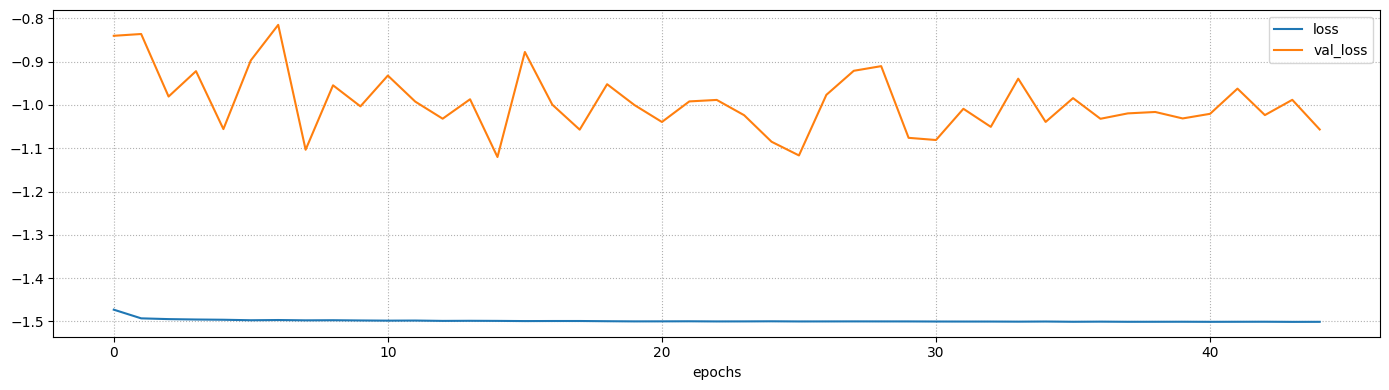

Final loss: -1.5010 (training), -1.0566 (validation)


In [264]:
X_train_map = inputs_train_map.values
X_val_map = inputs_val_map.values
X_test_map = inputs_test_map.values

print('Training the model with only MAP descriptor...')
map_model = build_nn_beta_model(input_shape=(X_train_map.shape[1],), hidden=[256,128]) #[256,128]
history = util.train_nn_model(map_model, X_train_map, y_train, batch_size, loss_prof, lr, epochs, verbose=1, patience=patience, validation_data=(X_val_map, y_val))
util.plot_training_history(history, figsize=(14, 4))


### 3.2 Full-model

Training the model with all morphoclimatic descriptors...
Epoch 1/90
1823/1823 [==============================] - 4s 2ms/step - loss: -1.4665 - val_loss: -0.6771
Epoch 2/90
1823/1823 [==============================] - 3s 1ms/step - loss: -1.4970 - val_loss: -0.6399
Epoch 3/90
1823/1823 [==============================] - 3s 1ms/step - loss: -1.5028 - val_loss: -1.0221
Epoch 4/90
1823/1823 [==============================] - 3s 1ms/step - loss: -1.5054 - val_loss: -0.9197
Epoch 5/90
1823/1823 [==============================] - 3s 1ms/step - loss: -1.5074 - val_loss: -1.0349
Epoch 6/90
1823/1823 [==============================] - 3s 1ms/step - loss: -1.5092 - val_loss: -0.7947
Epoch 7/90
1823/1823 [==============================] - 3s 1ms/step - loss: -1.5105 - val_loss: -0.8656
Epoch 8/90
1823/1823 [==============================] - 3s 1ms/step - loss: -1.5120 - val_loss: -1.0568
Epoch 9/90
1823/1823 [==============================] - 3s 1ms/step - loss: -1.5128 - val_loss: -0.9414
Epoch 

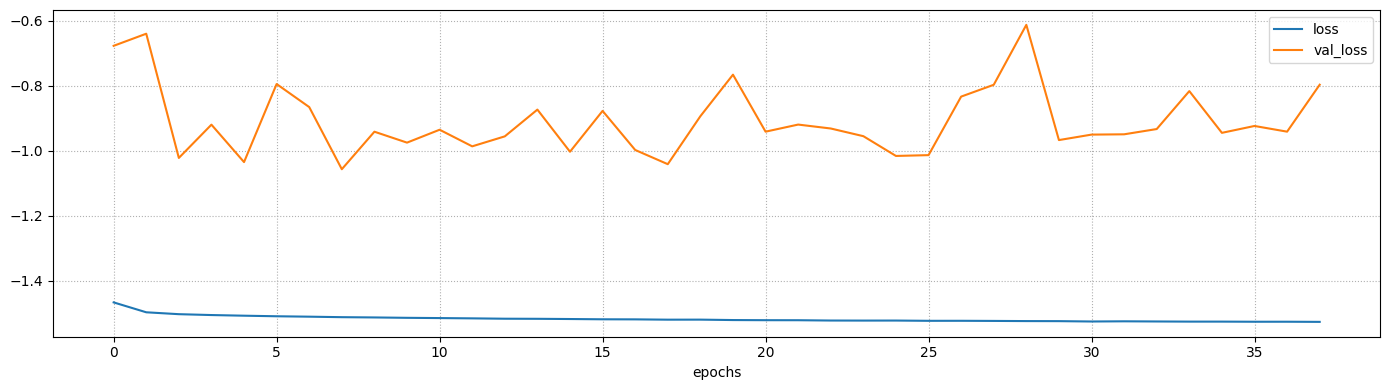

Final loss: -1.5264 (training), -0.7968 (validation)


In [265]:
X_train = inputs_train.values
X_val = inputs_val.values
X_test = inputs_test.values

print('Training the model with all morphoclimatic descriptors...')
full_model = build_nn_beta_model(input_shape=(X_train.shape[1],), hidden=[256,128]) #[256,128]
history = util.train_nn_model(full_model, X_train, y_train, batch_size, loss_prof, lr, epochs, verbose=1, patience=patience, validation_data=(X_val, y_val))
util.plot_training_history(history, figsize=(14, 4))

### 3.3  PCA-model

Training the model with the PCA of the morphoclimatic descriptors...


Epoch 1/90
1823/1823 [==============================] - 4s 2ms/step - loss: -1.4507 - val_loss: -0.7012
Epoch 2/90
1823/1823 [==============================] - 2s 1ms/step - loss: -1.4968 - val_loss: -0.7485
Epoch 3/90
1823/1823 [==============================] - 2s 1ms/step - loss: -1.5007 - val_loss: -1.0212
Epoch 4/90
1823/1823 [==============================] - 2s 1ms/step - loss: -1.5032 - val_loss: -0.9029
Epoch 5/90
1823/1823 [==============================] - 2s 1ms/step - loss: -1.5040 - val_loss: -1.0504
Epoch 6/90
1823/1823 [==============================] - 3s 1ms/step - loss: -1.5046 - val_loss: -0.8338
Epoch 7/90
1823/1823 [==============================] - 4s 2ms/step - loss: -1.5055 - val_loss: -0.8713
Epoch 8/90
1823/1823 [==============================] - 3s 2ms/step - loss: -1.5063 - val_loss: -1.0514
Epoch 9/90
1823/1823 [==============================] - 3s 2ms/step - loss: -1.5062 - val_loss: -0.9646
Epoch 10/90
1823/1823 [==============================] - 3s 2ms/

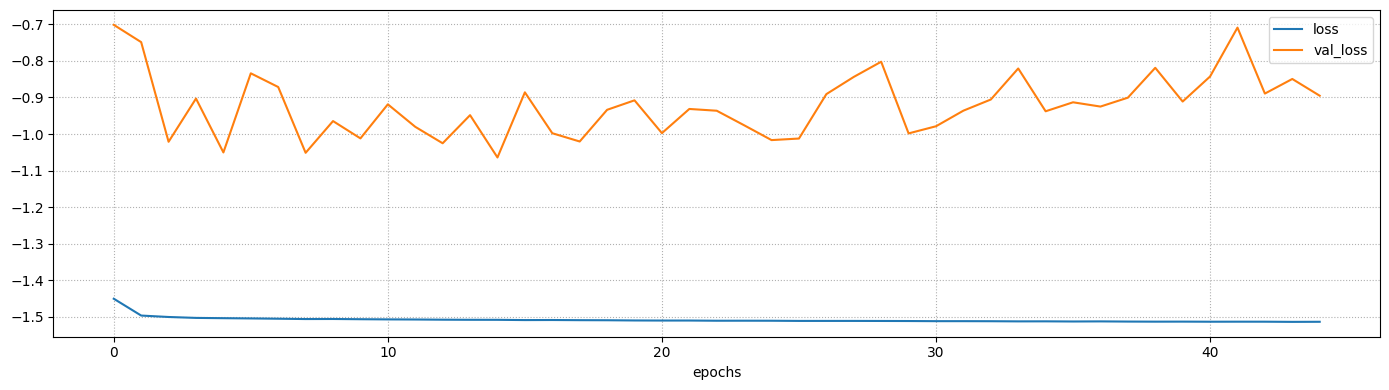

Final loss: -1.5138 (training), -0.8951 (validation)


In [266]:
X_train_pca = inputs_train_pca.values
X_val_pca = inputs_val_pca.values
X_test_pca = inputs_test_pca.values

print('Training the model with the PCA of the morphoclimatic descriptors...')
pca_model = build_nn_beta_model(input_shape=(X_train_pca.shape[1],), hidden=[256,128]) #[256,128]
history = util.train_nn_model(pca_model, X_train_pca, y_train, batch_size, loss_prof, lr, epochs, verbose=1, patience=patience, validation_data=(X_val_pca, y_val))
util.plot_training_history(history, figsize=(14, 4))

## 4. Evaluation

In [267]:
results = pd.DataFrame()

In [268]:
model_names = [ 'MAP', 'Full', 'PCA']
splits = ['Train', 'Validation', 'Test']
models = [map_model, full_model, pca_model]
X_values = {'MAP':[X_train_map, X_val_map, X_test_map], 'Full':[X_train, X_val, X_test], 'PCA':[X_train_pca, X_val_pca, X_test_pca]}
y_values = [y_train, y_val, y_test]
k = 0
for i, model_name in enumerate(model_names): 
    for j in range(3): #splits
        results[k] = util.evaluation(models[i], X_values[model_name][j], y_values[j], model_name, splits[j])
        k += 1

dist_train_map = map_model(X_train_map)
dist_val_map = map_model(X_val_map)
dist_test_map = map_model(X_test_map)

dist_train_full = full_model(X_train)
dist_val_full = full_model(X_val)
dist_test_full = full_model(X_test)

dist_train_pca = pca_model(X_train_pca)
dist_val_pca = pca_model(X_val_pca)
dist_test_pca = pca_model(X_test_pca)


Evaluating the MAP model on Train set...
Evaluating the MAP model on Validation set...
Evaluating the MAP model on Test set...
Evaluating the Full model on Train set...
Evaluating the Full model on Validation set...
Evaluating the Full model on Test set...
Evaluating the PCA model on Train set...
Evaluating the PCA model on Validation set...
Evaluating the PCA model on Test set...


In [269]:
results = results.T
results.columns=['Split', 'MAE', 'KS statistics']
display(results)

,Split,MAE,KS statistics
0,Train,0.064738,0.10085
1,Validation,0.074946,0.201744
2,Test,0.084,0.205583
3,Train,0.062611,0.090786
4,Validation,0.074454,0.199467
5,Test,0.083814,0.226318
6,Train,0.064034,0.088295
7,Validation,0.075034,0.217411
8,Test,0.084427,0.222685


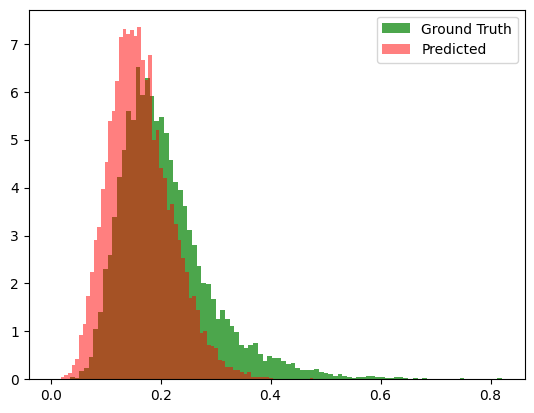

In [270]:
y_pred = dist_test_full.sample(1).numpy().ravel()
# y_pred = dist_train_map.sample(1).numpy().ravel()
# y_pred = dist_test_pca.sample(1).numpy().ravel()

util.plot_metrics(y_test, y_pred, 'red')

### 5.1.1 Distribution mean - confidence interval 

In [271]:
confidence = 0.99

Evaluation of MAP-model based on confidence intervals..


/usr/local/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:700: RuntimeWarning: invalid value encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)


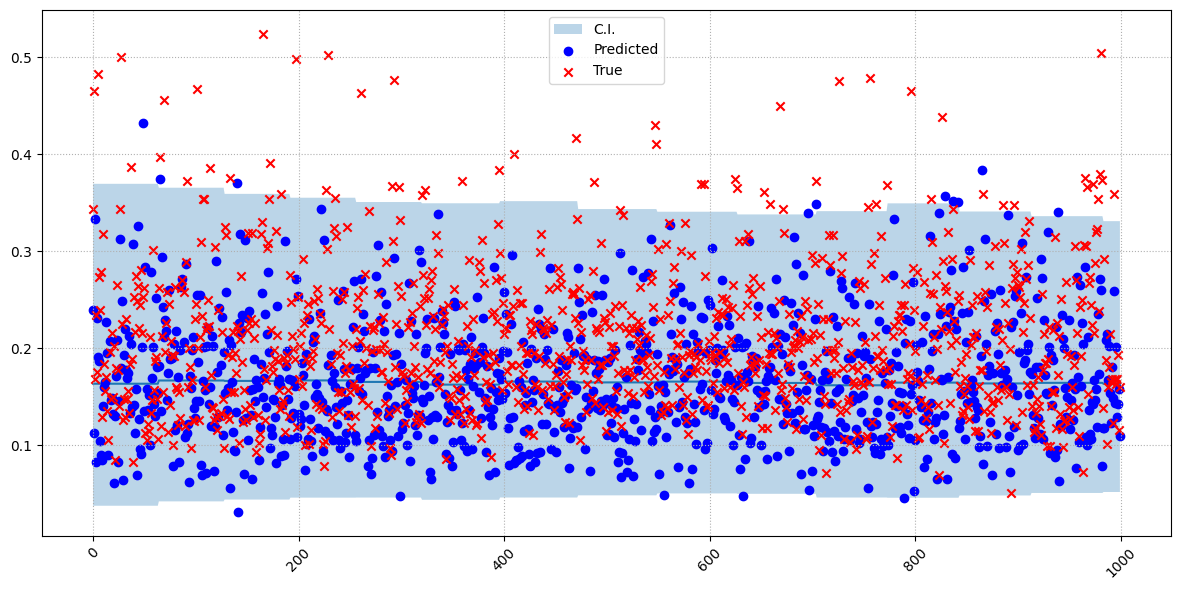

Percentage of values inside the 99% confidence interval: 93.01%


In [272]:
print('Evaluation of MAP-model based on confidence intervals..')
inside = util.percentage_in_ci(inputs_test_map, y_test, dist_test_map, confidence, distribution = 'beta', end = 1000)
print(f'Percentage of values inside the {confidence*100:.0f}% confidence interval: {inside:.2f}%')

Evaluation of Full-model based on confidence intervals..


/usr/local/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:700: RuntimeWarning: invalid value encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)


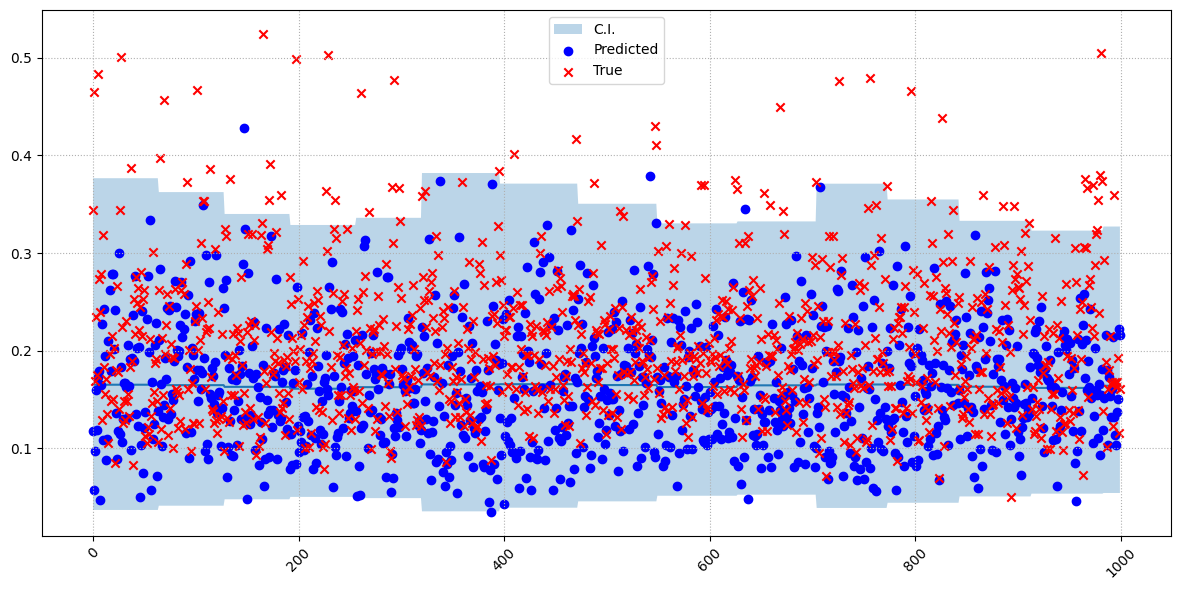

Percentage of values inside the 99% confidence interval: 91.59%


In [273]:
print('Evaluation of Full-model based on confidence intervals..')
inside = util.percentage_in_ci(inputs_test, y_test, dist_test_full, confidence, distribution = 'beta', end = 1000)
print(f'Percentage of values inside the {confidence*100:.0f}% confidence interval: {inside:.2f}%')

Evaluation of PCA-model based on confidence intervals..


/usr/local/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:700: RuntimeWarning: invalid value encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)


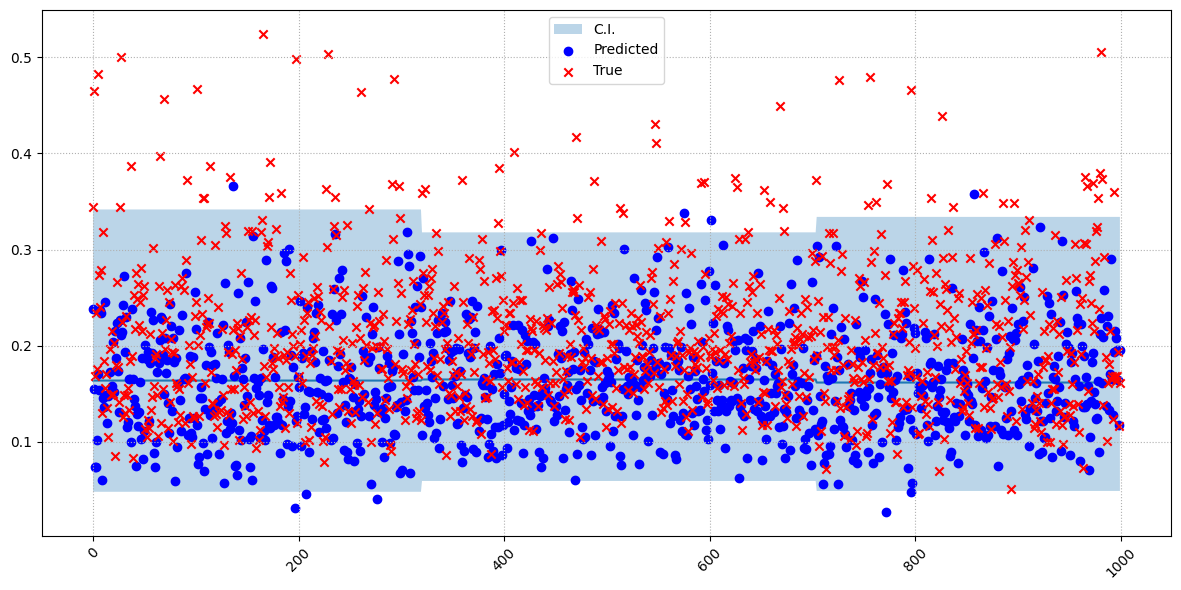

Percentage of values inside the 99% confidence interval: 91.96%


In [274]:
print('Evaluation of PCA-model based on confidence intervals..')
inside = util.percentage_in_ci(inputs_test_pca, y_test, dist_test_pca, confidence, distribution = 'beta', end = 1000)
print(f'Percentage of values inside the {confidence*100:.0f}% confidence interval: {inside:.2f}%')

## 5. Parameters

* Metrics on parameters from MAP-model

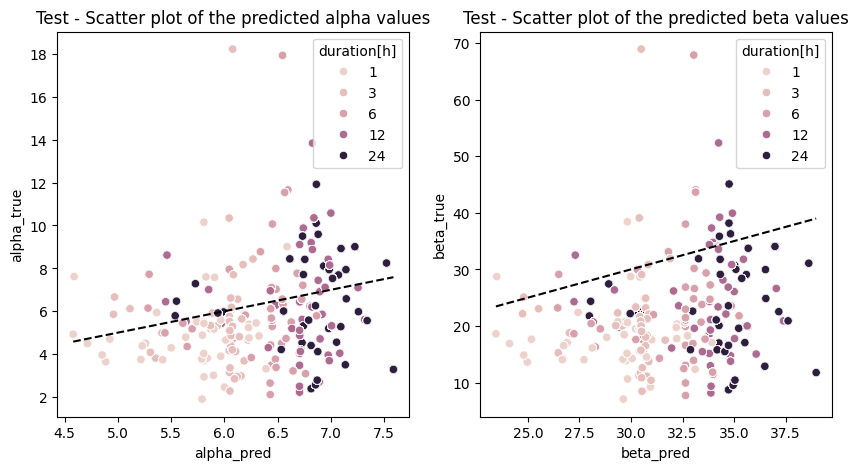

In [275]:
#Train
#_ = util.parameters_metrics(dist_train_map, parameters_train, distribution_name = 'beta', calculate_metrics = False, title='Train') 
#Test
metrics_alpha_map, metrics_beta_map = util.parameters_metrics(dist_test_map, parameters_test, distribution_name='beta', indexes=durations_indexes_test, remove_outliers = False)

In [276]:
print('===============ALPHA PARAMETER===============')
display(metrics_alpha_map)
print('===============BETA PARAMETER===============')
metrics_beta_map

===============ALPHA PARAMETER===============


,global,1,3,6,12,24
biasr,-0.222749,-0.317125,-0.228727,-0.189867,-0.197912,-0.179980
mape,0.363381,0.396952,0.352174,0.365822,0.361625,0.340263
pcc,0.223140,0.090613,0.026084,0.113623,0.058542,0.054677


===============BETA PARAMETER===============


,global,1,3,6,12,24
biasr,-0.651874,-0.804141,-0.647339,-0.605180,-0.606915,-0.595602
mape,0.688104,0.820083,0.690275,0.667527,0.648193,0.614218
pcc,0.201813,0.096731,0.020640,0.098286,0.034848,0.041502


* Metrics on parameters from Full-model

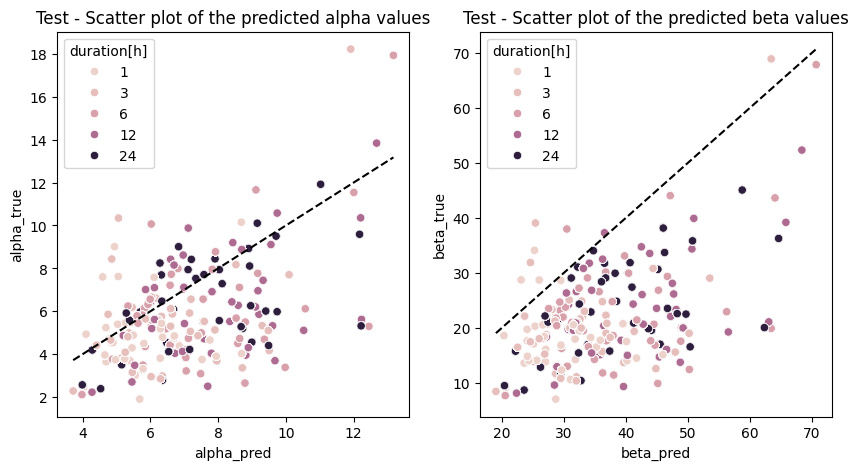

In [277]:
#train
#_ = util.parameters_metrics(dist_train_full, parameters_train, distribution_name = 'beta', calculate_metrics = False, title='Train')
#test
metrics_alpha_full, metrics_beta_full = util.parameters_metrics(dist_test_full, parameters_test, distribution_name='beta', indexes=durations_indexes_test, remove_outliers = False)

In [278]:
print('=============== FULL ALPHA PARAMETER===============')
display(metrics_alpha_full)
print('=============== FULL BETA PARAMETER===============')
metrics_beta_full

=============== FULL ALPHA PARAMETER===============


,global,1,3,6,12,24
biasr,-0.340291,-0.340804,-0.332154,-0.370635,-0.385271,-0.272439
mape,0.424235,0.435503,0.423615,0.461478,0.459259,0.341130
pcc,0.483755,0.131400,0.433848,0.485465,0.450480,0.475745


=============== FULL BETA PARAMETER===============


,global,1,3,6,12,24
biasr,-0.831184,-0.827656,-0.809251,-0.874289,-0.910356,-0.734147
mape,0.846030,0.851907,0.844380,0.887752,0.911713,0.734147
pcc,0.490985,0.120385,0.451944,0.507867,0.459143,0.476152


* Metrics on parameters from PCA-model

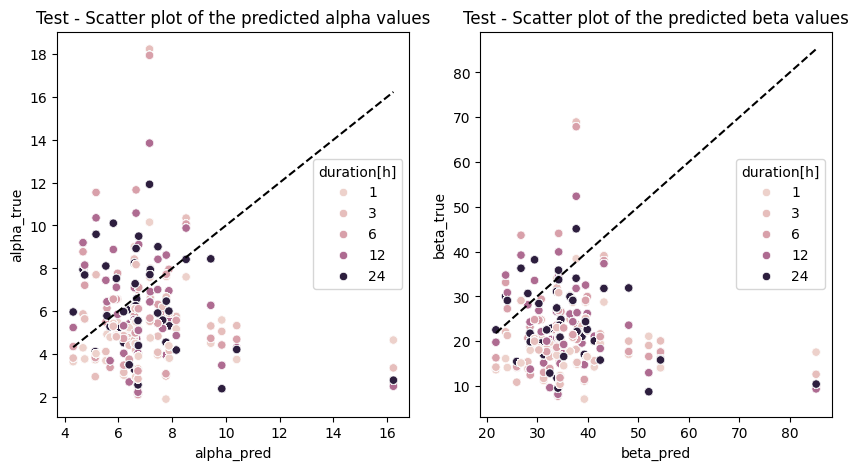

In [279]:
#_ = util.parameters_metrics(dist_train_pca, parameters_train, distribution_name = 'beta', calculate_metrics = False, title='Train')
metrics_alpha_pca, metrics_beta_pca = util.parameters_metrics(dist_test_pca, parameters_test, distribution_name='beta', indexes=durations_indexes_test, remove_outliers = False)

In [280]:
print('=============== PCA ALPHA PARAMETER===============')
display(metrics_alpha_pca)
print('=============== PCA BETA PARAMETER===============')
metrics_beta_pca

=============== PCA ALPHA PARAMETER===============


,global,1,3,6,12,24
biasr,-0.360606,-0.569016,-0.412088,-0.315633,-0.271263,-0.234680
mape,0.506378,0.596534,0.518740,0.494977,0.477613,0.443855
pcc,-0.092478,0.146301,0.035766,-0.142439,-0.223928,-0.249592


=============== PCA BETA PARAMETER===============


,global,1,3,6,12,24
biasr,-0.859896,-1.140636,-0.928637,-0.799444,-0.739885,-0.690409
mape,0.908925,1.141759,0.956116,0.877772,0.815071,0.753479
pcc,-0.084841,0.155691,0.050279,-0.128842,-0.221263,-0.251856


### 6.1 Comparison between two samples extracted from "true" and predicted distribution of the same place 

True alpha :  4.6982198724470905 Predicted  alpha : 5.9276385
True beta :  17.654443133826256 Predicted  beta : 30.466497


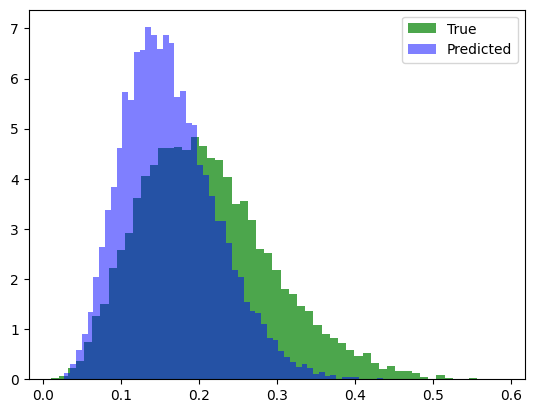

In [281]:
util.compare_samples(dist_train_full, "beta", parameters_test, index=20)
#util.compare_samples(dist_train_map, "beta", parameters_train, index=20)
#util.compare_samples(dist_train_pca, "beta", parameters_train, index=20)

## 6. Error Analysis


### 6.1 Beta Distribution

In [282]:
metrics_name = ['biasr', 'mape', 'pcc']
models_name = ['map', 'full', 'pca']
models_metrics = [ metrics_alpha_map, metrics_alpha_full, metrics_alpha_pca]

In [283]:
alpha_metrics = util.get_global_results(metrics_name,models_name,models_metrics)
alpha_metrics

,biasr_map,biasr_full,biasr_pca,mape_map,mape_full,mape_pca,pcc_map,pcc_full,pcc_pca
global,-0.222749,-0.340291,-0.360606,0.363381,0.424235,0.506378,0.223140,0.483755,-0.092478
1,-0.317125,-0.340804,-0.569016,0.396952,0.435503,0.596534,0.090613,0.131400,0.146301
3,-0.228727,-0.332154,-0.412088,0.352174,0.423615,0.518740,0.026084,0.433848,0.035766
6,-0.189867,-0.370635,-0.315633,0.365822,0.461478,0.494977,0.113623,0.485465,-0.142439
12,-0.197912,-0.385271,-0.271263,0.361625,0.459259,0.477613,0.058542,0.450480,-0.223928
24,-0.179980,-0.272439,-0.234680,0.340263,0.341130,0.443855,0.054677,0.475745,-0.249592


In [284]:
models_metrics = [ metrics_beta_map, metrics_beta_full, metrics_beta_pca]
beta_metrics = util.get_global_results(metrics_name,models_name,models_metrics)
beta_metrics

,biasr_map,biasr_full,biasr_pca,mape_map,mape_full,mape_pca,pcc_map,pcc_full,pcc_pca
global,-0.651874,-0.831184,-0.859896,0.688104,0.846030,0.908925,0.201813,0.490985,-0.084841
1,-0.804141,-0.827656,-1.140636,0.820083,0.851907,1.141759,0.096731,0.120385,0.155691
3,-0.647339,-0.809251,-0.928637,0.690275,0.844380,0.956116,0.020640,0.451944,0.050279
6,-0.605180,-0.874289,-0.799444,0.667527,0.887752,0.877772,0.098286,0.507867,-0.128842
12,-0.606915,-0.910356,-0.739885,0.648193,0.911713,0.815071,0.034848,0.459143,-0.221263
24,-0.595602,-0.734147,-0.690409,0.614218,0.734147,0.753479,0.041502,0.476152,-0.251856


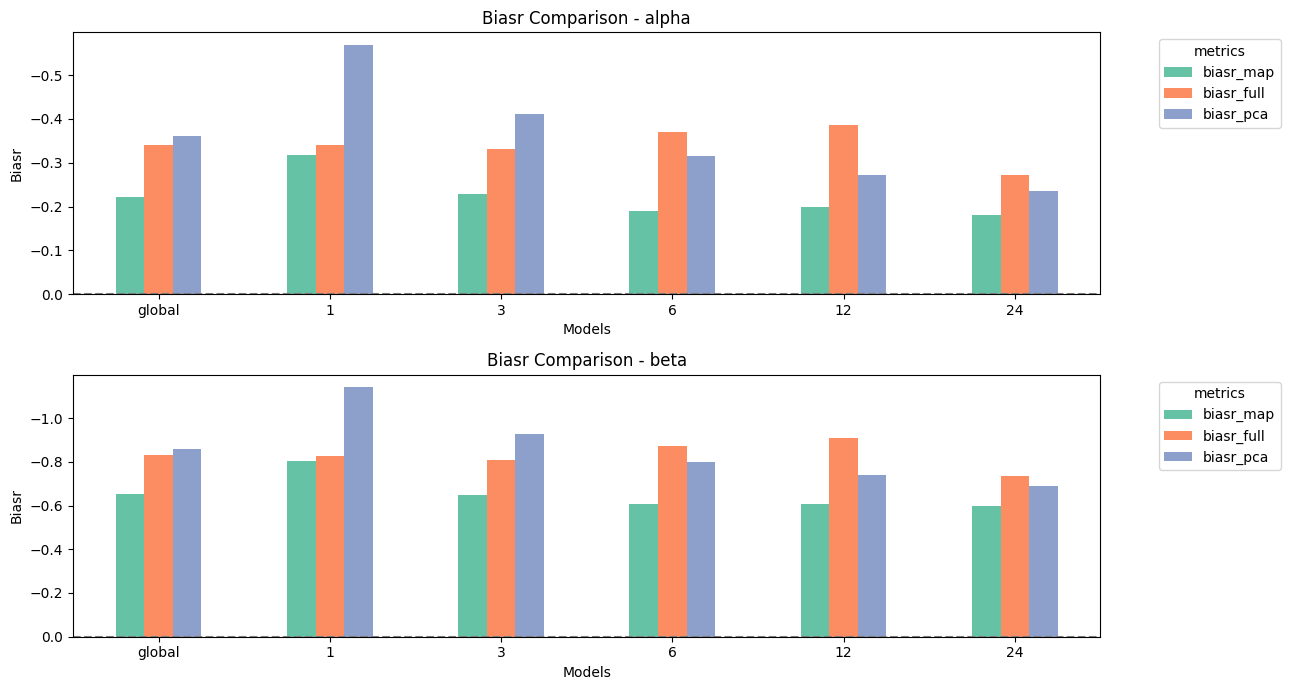

In [285]:
util.get_comparison_plot(alpha_metrics.iloc[:,0:3], beta_metrics.iloc[:,0:3], 'Biasr','beta', 'Set2')

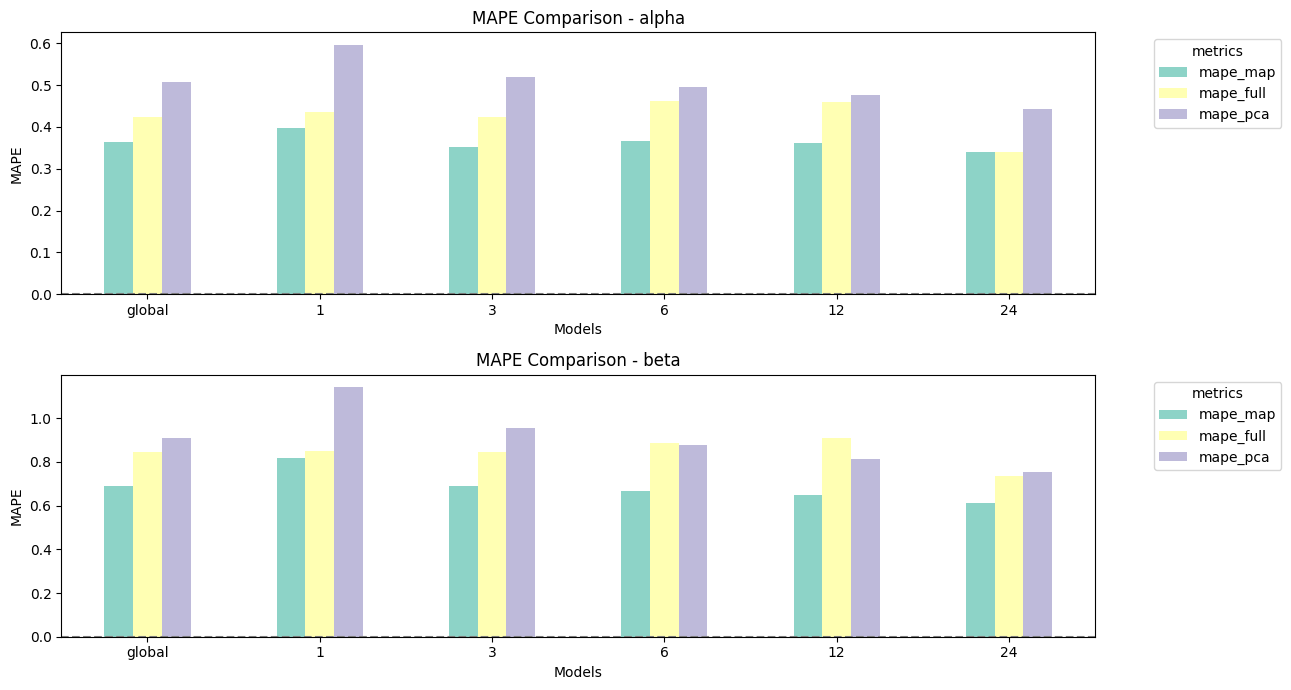

In [286]:
util.get_comparison_plot(alpha_metrics.iloc[:,3:6], beta_metrics.iloc[:,3:6], 'MAPE', 'beta','Set3')

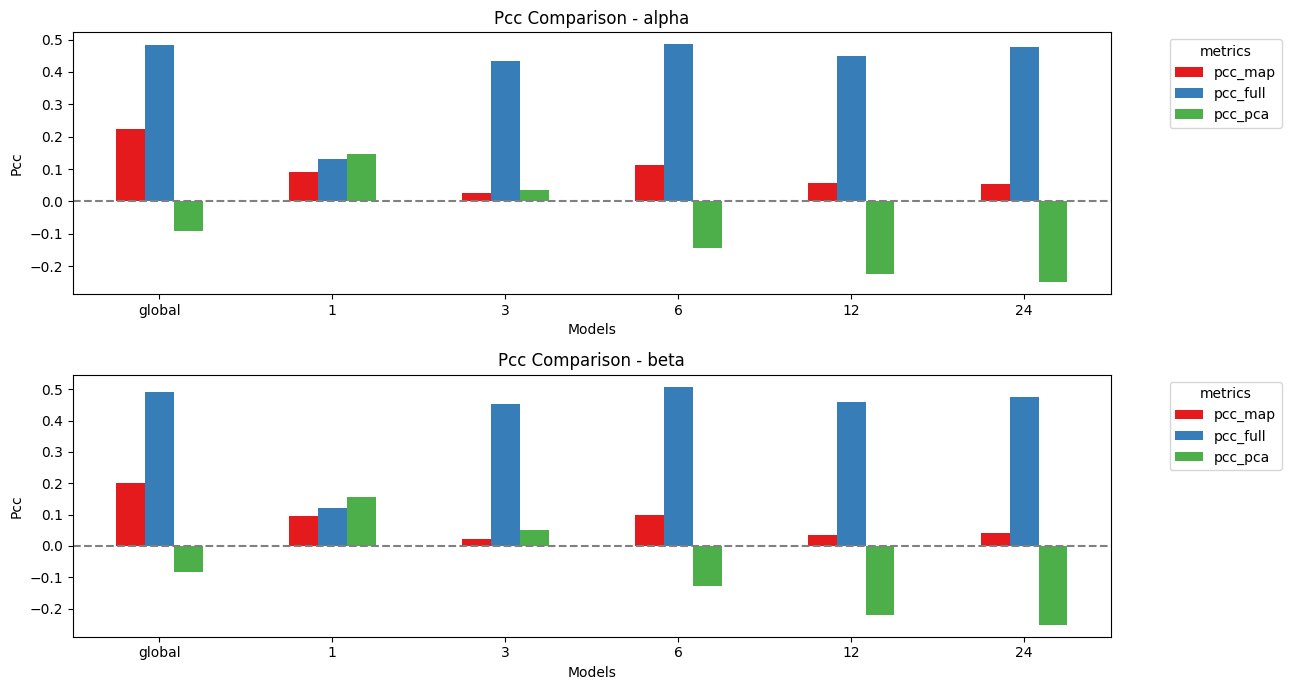

In [287]:
util.get_comparison_plot(alpha_metrics.iloc[:,6:9], beta_metrics.iloc[:,6:9], 'Pcc','beta', 'Set1')

The metrics used to evaluate the predictions on alpha and beta are: RMSE (Root Mean Squared Error), Relative Bias, and PCC (Pearson Correlation Coefficient).
- RMSE: It measures the difference between the values predicted by a model and the observed values, a lower value indicates better model accuracy. 
This is likely due to the wide variability in parameter values, making the model more prone to incorrectly predicting high values of alpha and beta.

- RBIAS:
If it is close to zero indicates that the model has a good tendency to predict values correctly, when it is positive the model tend to overestimate, while a negative relative bias indicates a tendency to underestimate the parameter.
 The Beta models tend to understimate the value of alpha and beta, in particular when considering the duration 1.

- PCC: It is a measure of the linear relationship between two variables.
It can range from -1 to 1. A value of 1 indicates a perfect positive correlation, -1 indicates a perfect negative correlation, and 0 indicates no linear correlation.



Observing the graph, one of the first notable things is that the models show specular performance in predicting alpha and in predicting beta. Global metrics do not always reflect what is obtained considering the individual durations in which the use of one model rather than the other can lead to different results.

( Sta cosa non ha nessun senso poi indago )
Comparing the different models, the best-performing one appears to be the MAP model, while the least performing one is the PCA model.

### 6.2 Gumbel Distribution

In [288]:
loc_metrics = pd.read_pickle('results/loc_metrics.pkl')
scale_metrics = pd.read_pickle('results/scale_metrics.pkl')

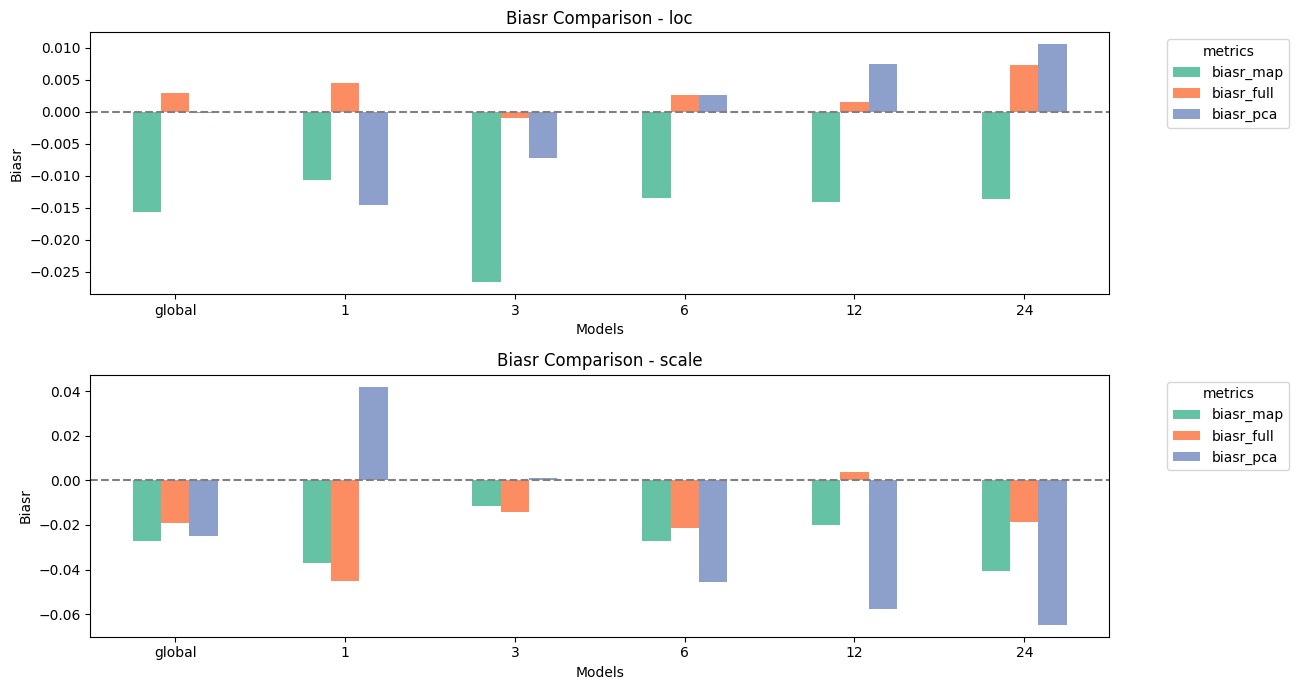

In [289]:
util.get_comparison_plot(loc_metrics.iloc[:,0:3], scale_metrics.iloc[:,0:3], 'Biasr','gumbel','Set2')

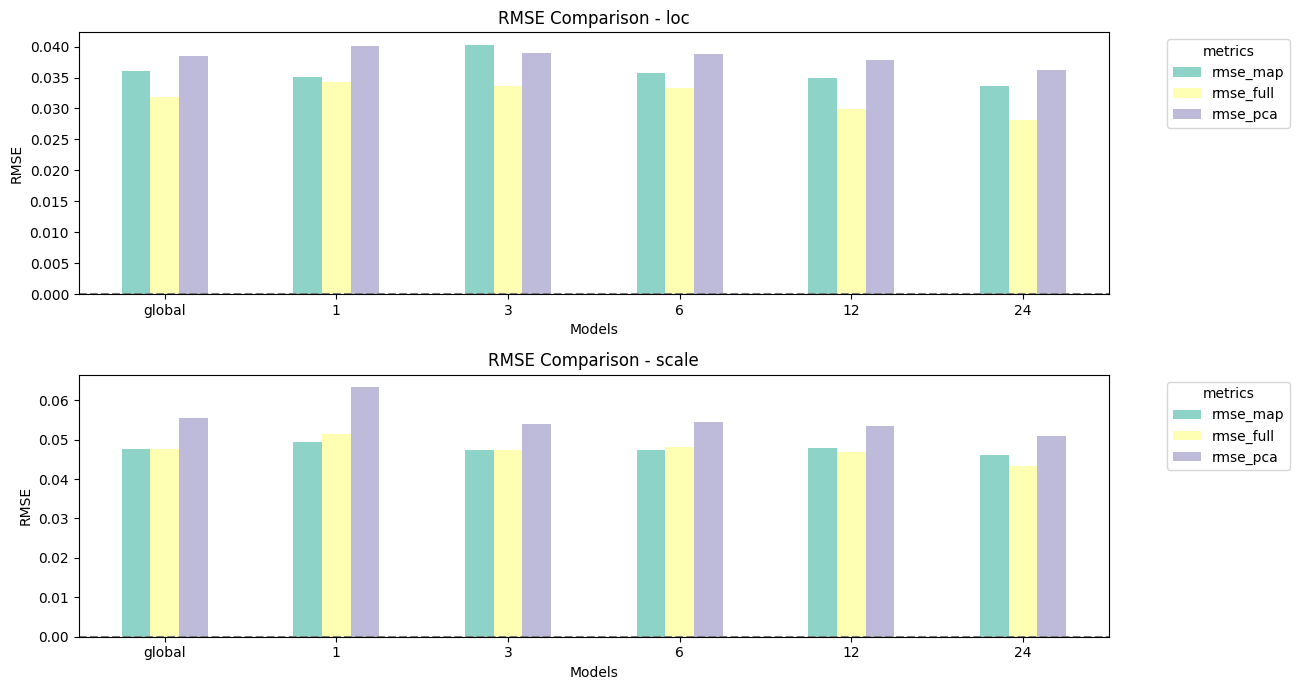

In [290]:
util.get_comparison_plot(loc_metrics.iloc[:,3:6], scale_metrics.iloc[:,3:6], 'RMSE', 'gumbel', 'Set3')

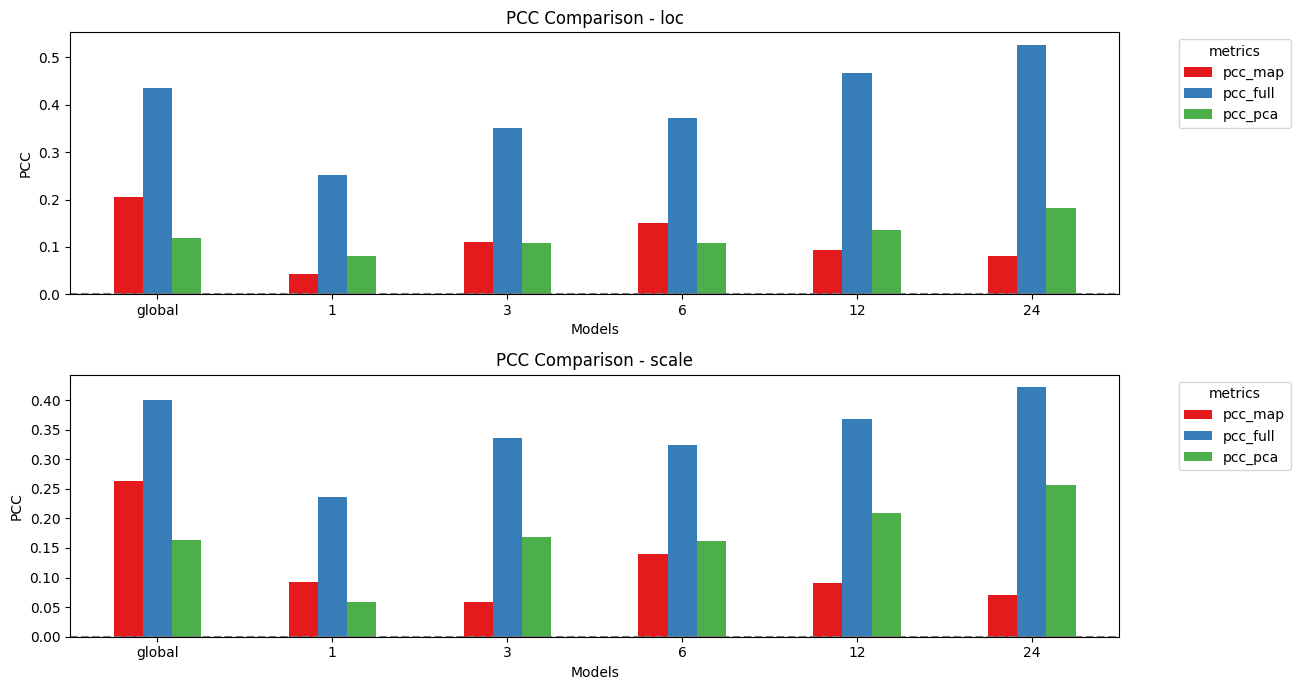

In [291]:
util.get_comparison_plot(loc_metrics.iloc[:,6:9], scale_metrics.iloc[:, 6:9], 'PCC', 'gumbel', 'Set1')

The results of the Gumbel are less symmetrical than those obtained with the Beta distribution. Observing the various metrics, the models therefore obtain different results for location and scale. In particular, the MAP model and the full model show similar results, generally better than those obtained through PCA

The metrics suggest that:

- All three models are capable of estimating the parameters fairly accurately with minimal errors (RMSE), often slightly underestimating them (RBias).
- The data does not exhibit a strong linear relationship (PCC)

### 6.3 Distributions Comparison

Since the results are all around the same order of magnitude, to compare the distributions we consider the 'global' values 

In [292]:
biasr_comparison = pd.DataFrame()

In [293]:
biasr_comparison["loc"] = loc_metrics.iloc[0,0:3].values
biasr_comparison["scale"] = scale_metrics.iloc[0,0:3].values
biasr_comparison["alpha"] = alpha_metrics.iloc[0,0:3].values
biasr_comparison["beta"] = beta_metrics.iloc[0,0:3].values

In [294]:
biasr_comparison.index = ['map', 'full', 'pca']
biasr_comparison

,loc,scale,alpha,beta
map,-0.015624,-0.027339,-0.222749,-0.651874
full,0.003005,-0.019154,-0.340291,-0.831184
pca,-0.000208,-0.024997,-0.360606,-0.859896


In [295]:
def plot_biasr_comparison(df, title):
  fig, ax = plt.subplots(figsize=(18, 7))
  colors = sns.color_palette("Set2", 4)
  df.plot(kind='bar', ax=ax, rot=0, color=colors)

  plt.title('Scores Comparison'+" - " + title)
  plt.xlabel('Models')
  plt.ylabel('F1 Score')
  plt.legend(title='metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
  ax.invert_yaxis()
  plt.tight_layout()

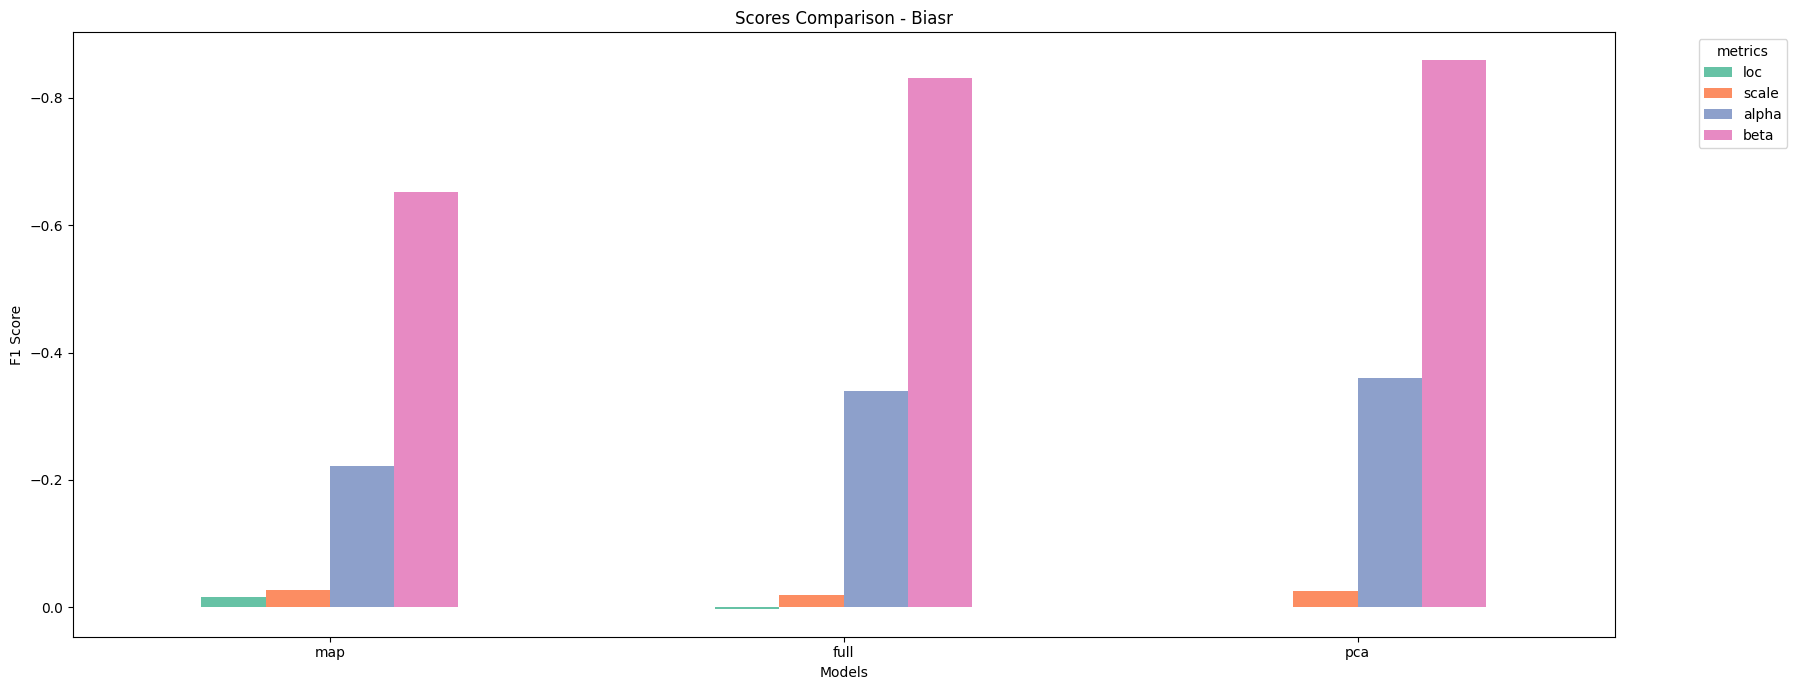

In [296]:
plot_biasr_comparison(biasr_comparison, 'Biasr')

For a more faithful comparison, we focused on the relative bias metrics as it is a dimensionless and independent of the magnitude of the values.
Observing the graph, it is evident that the estimates made by the Gumbel distribution are much more accurate than those of the Beta distribution,
However, it should be considered that we are considering the estimation made by the scipy fitter as the 'true' value for the parameter, and  there is no certainty that they are actually accurate. Greater confidence would be achieved if all measurements had an higher number of observations.